# 1 Python Configuration and Data Loading

In [2]:
import sys
if sys.version_info[0] < 3:
	raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import io


# 2 Data Partitioningand and Evaluation Metrics

In [3]:
def shuffle_train_val_split(data_name, val_amt=0, percent=0):
    data = np.load(f"C:/Users/a1362/Downloads/hw1/data/{data_name}-data.npz")
    total_data = data["training_data"].shape[0]
    shuffle = np.random.permutation(total_data)
    data_xtrain, data_ytrain = data["training_data"][shuffle], data["training_labels"][shuffle]
    
    if not val_amt:
        val_amt = int(percent * total_data)

    data_xval, data_yval = data_xtrain[:val_amt, :], data_ytrain[:val_amt]
    data_xtrain, data_ytrain = data_xtrain[val_amt:, :], data_ytrain[val_amt:]
    return data_xtrain, data_ytrain, data_xval, data_yval


In [4]:
mnist_xtrain, mnist_ytrain, mnist_xval, mnist_yval = \
shuffle_train_val_split("mnist", 10000)

spam_xtrain, spam_ytrain, spam_xval, spam_yval = \
shuffle_train_val_split("spam", percent = 0.2)

In [5]:
def accuracy_score(y, y_pred):
    n = len(y)
    sum = 0
    for i in range(n):
        if y[i] == y_pred[i]:
            sum += 1
    return (1/n) * sum


# 4 Support Vector Machines: Coding

In [6]:
training_size_mn = [100, 200, 500, 1000, 2000, 5000, 10000]
training_size_spam = [100, 200, 500, 1000, 2000, spam_xtrain.shape[0]]

def svc(training_examples, xtrain, ytrain, xval, yval):
    train_acy_set = []
    val_acy_set = []
    for size in training_examples:
        xtrain_subset = xtrain[:size]
        ytrain_subset = ytrain[:size]

        train_data_flat = xtrain_subset.reshape(size, -1)
        validation_data_flat = xval.reshape(xval.shape[0], -1)

        clf = svm.SVC(kernel = 'linear')

        clf.fit(train_data_flat, ytrain_subset)

        xtrain_flat = xtrain.reshape(xtrain.shape[0], -1)

        train_pred = clf.predict(xtrain_flat)
        val_pred = clf.predict(validation_data_flat)

        train_acy = accuracy_score(ytrain, train_pred)
        val_acy = accuracy_score(yval, val_pred)
        train_acy_set.append(train_acy)
        val_acy_set.append(val_acy)

    return train_acy_set, val_acy_set

In [7]:
mnist_train_acy, mnist_val_acy = svc(training_size_mn, mnist_xtrain, mnist_ytrain, mnist_xval, mnist_yval)
spam_train_acy, spam_val_acy = svc(training_size_spam, spam_xtrain, spam_ytrain, spam_xval, spam_yval)


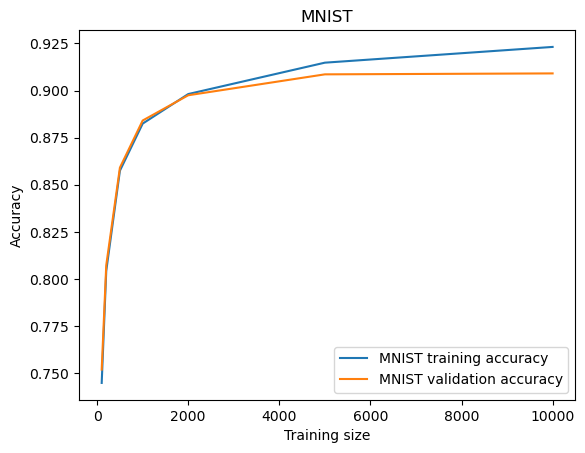

In [8]:
plt.plot(training_size_mn, mnist_train_acy, label='MNIST training accuracy')
plt.plot(training_size_mn, mnist_val_acy, label='MNIST validation accuracy')
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.title('MNIST')
plt.legend()
plt.show()

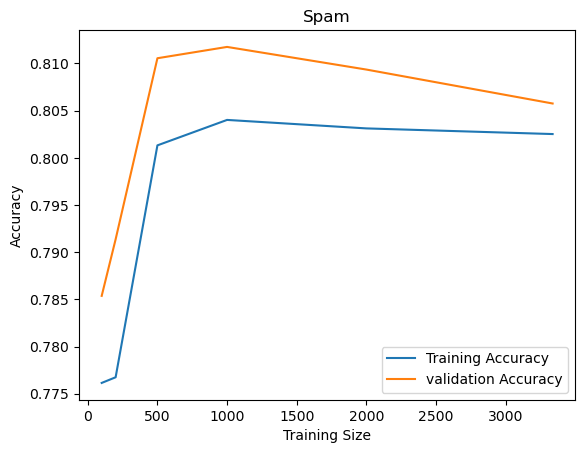

In [9]:
plt.plot(training_size_spam, spam_train_acy, label='Training Accuracy')
plt.plot(training_size_spam, spam_val_acy, label='validation Accuracy')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Spam')
plt.legend()
plt.show()

# 4 Hyperparameter Tuning

In [14]:
def train_hyper(xtrain, ytrain, xval, yval, size, kernel, c):
    xtrain_subset = xtrain[:size]
    ytrain_subset = ytrain[:size]

    train_data_flat = xtrain_subset.reshape(size, -1)
    validation_data_flat = xval.reshape(xval.shape[0], -1)
    clf = svm.SVC(kernel=kernel, C=c)
    clf.fit(train_data_flat, ytrain_subset)
    ypred = clf.predict(validation_data_flat)

    acy = accuracy_score(yval, ypred)
    return acy


In [20]:
size = 10000
C = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
mnist_val_acy = []
for c in C:
    acy = train_hyper(mnist_xtrain, mnist_ytrain, mnist_xval, mnist_yval, size, 'linear', c)
    mnist_val_acy.append(acy)

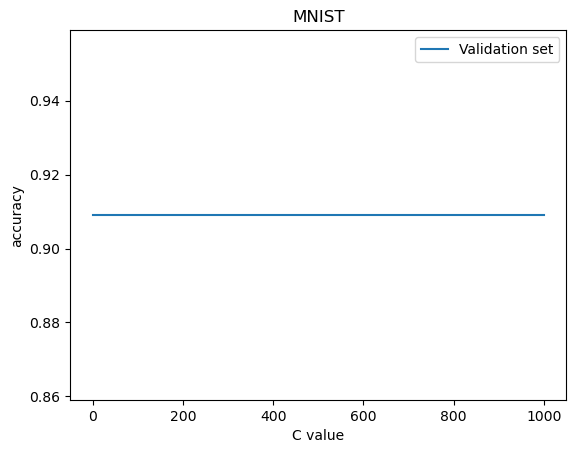

In [21]:
plt.plot(C, mnist_val_acy, label="Validation set")
plt.xlabel("C value")
plt.ylabel("accuracy")
plt.title("MNIST")
plt.legend()
plt.show()

In [22]:
temp = dict(zip(C, mnist_val_acy))
msg = ""
for c, err in temp.items():
    msg += str(c) + ": " + str(err) + "\n"
print("C values tried with corresponding validation accuracy "+ 
      "(C = key, accuracy = value): \n" + msg)
print("Best C value for MNIST is: " + 
      str(C[mnist_val_acy.index(max(mnist_val_acy))]))

C values tried with corresponding validation accuracy (C = key, accuracy = value): 
0.0001: 0.9091
0.001: 0.9091
0.01: 0.9091
0.1: 0.9091
1: 0.9091
10: 0.9091
100: 0.9091
1000: 0.9091

Best C value for MNIST is: 0.0001


In [23]:
from sklearn.preprocessing import StandardScaler


def k_fold_cross_validation_spam(c_value, k=5):
    data = np.load("C:/Users/a1362/Downloads/hw1/data/spam-data.npz")
    total_data = data["training_data"].shape[0]
    shuffle = np.random.permutation(total_data)
    data_xtrain, data_ytrain = data["training_data"][shuffle], data["training_labels"][shuffle]
    # scaler = StandardScaler().fit(data_xtrain)
    # data_xtrain = scaler.transform(data_xtrain)
    # data_ytrain = scaler.transform(data_ytrain)

    acy_set = []
    
    fold_size = total_data // k
    for fold in range(k):
        validation_start = fold * fold_size
        validation_end = (fold + 1) * fold_size
        validation_data = data_xtrain[validation_start:validation_end]
        validation_labels = data_ytrain[validation_start:validation_end]
        train_data = np.concatenate([data_xtrain[:validation_start], data_xtrain[validation_end:]])
        train_labels = np.concatenate([data_ytrain[:validation_start], data_ytrain[validation_end:]])

        clf = svm.SVC(kernel='linear', C=c_value)  
        clf.fit(train_data, train_labels)
        predictions = clf.predict(validation_data)
        acy = accuracy_score(validation_labels, predictions)
        acy_set.append(acy)
    
    return np.mean(acy_set)


In [24]:
spam_folds_val_acc = [k_fold_cross_validation_spam(c) for c in C]

In [25]:
temp = dict(zip(C, spam_folds_val_acc))
msg = ""
for c, acc in temp.items():
    msg += str(c) + ": " + str(acc) + "\n"
print("C values tried with corresponding Cross-Validation accuracies"+
      "\n(C = key, accuracy = value): \n" + msg)

C values tried with corresponding Cross-Validation accuracies
(C = key, accuracy = value): 
0.0001: 0.717505995203837
0.001: 0.7491606714628297
0.01: 0.7757793764988009
0.1: 0.7964028776978417
1: 0.8009592326139089
10: 0.8007194244604315
100: 0.804556354916067
1000: 0.8007194244604315



In [26]:
import pandas as pd

def results_to_csv(y_test, file_name):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1
    df.to_csv(file_name, index_label='Id')

mnist_data = np.load(f"C:/Users/a1362/Downloads/hw1/data/mnist-data.npz")
mnist_test = mnist_data['test_data']
spam_data = np.load(f"C:/Users/a1362/Downloads/hw1/data/spam-data.npz")
spam_test = spam_data['test_data']

mnist_xtrain, mnist_ytrain, mnist_xval, mnist_yval = \
shuffle_train_val_split("mnist", 6000)

spam_xtrain, spam_ytrain, spam_xval, spam_yval = \
shuffle_train_val_split("spam", 1000)

clf_mnist = svm.SVC(kernel='linear', C=0.0001)
clf_mnist.fit(mnist_xtrain.reshape(len(mnist_xtrain), -1), mnist_ytrain)
mnist_test_predictions = clf_mnist.predict(mnist_test.reshape(len(mnist_test), -1))
results_to_csv(mnist_test_predictions, 'mnist_predictions.csv')

clf_spam = svm.SVC(kernel='linear', C=1000)
clf_spam.fit(spam_xtrain.reshape(len(spam_xtrain), -1), spam_ytrain)
spam_test_predictions = clf_spam.predict(spam_test.reshape(len(spam_test), -1))
results_to_csv(spam_test_predictions,'spam_predictions.csv')